In [147]:
from Bio import Phylo
from io import StringIO

## Function to get the Mapping score (Smap) 

In [293]:
def mapping_traits(tree,dic_strain_host):
    from collections import Counter
    ''' This function use a tree Phylo object with a dictionary of the host of each strain (leaf)
        and return an Score of mapping (Smap)  '''
    # finding clades in the tree:
    # E.g.: {'clade_1': ['Strain_1', 'Strain_2', 'Strain_3'], 'clade_2': ['Strain_4', 'Strain_5'], ... }
    clades_found = find_clades(tree) # the description of this function is in the next cell
    
    # getting the host names of each leaf that belongs to each clade:
    # E.g.: {'clade_1': ['Host_A', 'Host_A', 'Host_A'], 'clade_2': ['Host_B', 'Host_B'], ...}
    dic_clade_hosts = {} 
    for k,v in clades_found.items():
        hosts = []
        for vi in v:
            hosts.append(dic_strain_host[vi])
        dic_clade_hosts[k] = hosts
        
    # counting the total of each hosts in the tree:
    # E.g.: {'Host_C': 5, 'Host_A': 3, 'Host_B': 2}
    dic_total_hosts = Counter(list(dic_strain_host.values()))
    
    # getting the number of host in the clade, number of leaf in the clade, number of host in the tree
    # E.g.: {'clade_1': {'Host_A': [3, 3, 3]}, 'clade_2': {'Host_B': [2, 2, 2]} ... }
    dic_clade_DictHostFreq = {}
    for k,v in dic_clade_hosts.items():
        counter_host = {}
        for ki,vi in Counter(v).items():
            counter_host[ki] = [vi , sum(list(Counter(v).values())) , dic_total_hosts[ki]]
        dic_clade_DictHostFreq[k] = counter_host
    
    # getting the porportion of each host (weigth) in the tree
    # E.g.: {'Host_A': 0.3, 'Host_B': 0.2, ... }
    dic_host_w = {}
    for k,v in dic_total_hosts.items():
        dic_host_w[k] = v/sum(list(dic_total_hosts.values()))
    
    # getting the clades where the host is present
    # E.g.: {'Host_A': [[3, 3, 3, 'clade_1']], 'Host_B': [[2, 2, 2, 'clade_2']], ... }
    dic_host = {}
    for k,v in dic_clade_DictHostFreq.items():
        for kv , vv in v.items():
            vv.append(k)
            if kv in dic_host:
                dic_host[kv].append(vv)
            else:
                dic_host[kv] = [vv]
                
    # getting the score of each host in the tree
    # E.g.: {'Host_A': [0.3, 'clade_1'], 'Host_B': [0.2, 'clade_2'],  ... }
    dic_host_norm = {}
    for host , info in dic_host.items():
        new_info = []
        for i in info:
            score1 = (i[0]/i[1])
            score2 = (i[0]/i[2])
            score_norm = round(score1*score2*dic_host_w[host] , 5)
            new_info.append([score_norm , i[3]])
        # retrieving the best score of the host
        new_info.sort(key=lambda x: x[0],reverse=True)
        dic_host_norm[host] = new_info[0]
        print(host,': ',new_info[0][0],' (host score)')
        
    # calculing the score of mapping of the tree    
    Smapp = sum(list(s[0] for s in list(dic_host_norm.values())))
    print()
    print('<< Smap: ',Smapp,' (Tree score) >>')
    return Smapp

## Function to find clades in a phylogenetic tree 

In [294]:
def find_clades(tree):
    import statistics as sta
    ''' This function take a Phylo object and return a dictionary with the principal clades.
           The criteria to consider one clade is:
           'Leafs (external branchs) closely separated by internal branchs '''
    # Rooting and ordering the tree topology
    tree.root_at_midpoint()
    tree.ladderize()
    
    # Making a list of the branch length and names of each element (internal and external branchs)
    tree_list = []
    for i in tree.find_clades():
        tree_list.append([i.branch_length,i.name])

    # Iterating each element of tree_list and deciding the integrants of a clade
    i , j = 0 , 0
    temporal_dic_clades = {}
    while i < len(tree_list):
        j = i
        # In the following while could be use the branch length (tree_list[j][0])
        # to more resolution of the clades found (after evaluation of the total branchs in the tree)
        while j < len(tree_list) and tree_list[j][1] != None:
            key = "clade_number_temporal"+str(i)
            value = tree_list[j][1]
            if not key in temporal_dic_clades:
                temporal_dic_clades[key] = [value]
            else:
                temporal_dic_clades[key].append(value)
            j += 1
        if j > i:
            i = j
        else:
            i += 1
    # Iterating the dictionary to change the key temporal names
    final_dic_clades , c = {} , 0
    for k,v in temporal_dic_clades.items():
        c += 1
        final_dic_clades['clade_'+str(c)] = v
    return final_dic_clades

## Examples

In [295]:
# tree in newick format
tree_nwk = '((Strain_5:0.0001,Strain_4:0.0001):0.001,(Strain_1:0.0001,Strain_3:0.0001,\
            Strain_2:0.0001):0.005321864,(Strain_10:0.0001,Strain_9:0.0001,Strain_8:0.0001,Strain_7:0.0001,\
            Strain_6:0.0001):0.002)'

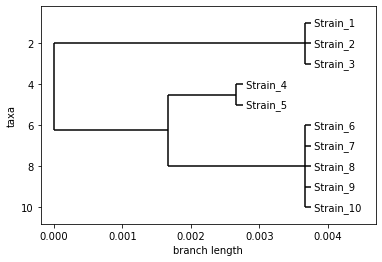

In [296]:
# drawing the example tree
tree = Phylo.read(StringIO(tree_nwk), 'newick')
tree.root_at_midpoint()
tree.ladderize(reverse=False)
Phylo.draw(tree)

**EXAMPLE 1 (Each host group mapped eactly in one clade)**<br>
Strain_1 --> Host_A<br>Strain_2 --> Host_A<br>Strain_3 --> Host_A<br>Strain_4 --> Host_B<br>Strain_5 --> Host_B<br>Strain_6 --> Host_C<br>Strain_7 --> Host_C<br>Strain_8 --> Host_C<br>Strain_9 --> Host_C<br>Strain_10 --> Host_C

In [297]:
dic_strain_host_example1 = {'Strain_1':'Host_A','Strain_2':'Host_A','Strain_3':'Host_A',
                            'Strain_4':'Host_B','Strain_5':'Host_B',
                            'Strain_6':'Host_C','Strain_7':'Host_C','Strain_8':'Host_C','Strain_9':'Host_C','Strain_10':'Host_C'}

In [298]:
# Calculating the scores for the example 1
Smap_example1 = mapping_traits(tree,dic_strain_host_example1)

Host_A :  0.3  (host score)
Host_B :  0.2  (host score)
Host_C :  0.5  (host score)

<< Smap:  1.0  (Tree score) >>


**EXAMPLE 2 (The hosts mapped in different clades)**<br>
Strain_1 --> Host_C<br>Strain_2 --> Host_C<br>Strain_3 --> Host_A<br>Strain_4 --> Host_B<br>Strain_5 --> Host_B<br>Strain_6 --> Host_A<br>Strain_7 --> Host_A<br>Strain_8 --> Host_C<br>Strain_9 --> Host_C<br>Strain_10 --> Host_C

In [299]:
dic_strain_host_example2 = {'Strain_1':'Host_C','Strain_2':'Host_C','Strain_3':'Host_A',
                            'Strain_4':'Host_B','Strain_5':'Host_B',
                            'Strain_6':'Host_A','Strain_7':'Host_A','Strain_8':'Host_C','Strain_9':'Host_C','Strain_10':'Host_C'}

In [301]:
# Calculating the scores for the example 2
Smap_example2 = mapping_traits(tree,dic_strain_host_example2)

Host_C :  0.18  (host score)
Host_A :  0.08  (host score)
Host_B :  0.2  (host score)

<< Smap:  0.46  (Tree score) >>
